<a href="https://colab.research.google.com/github/james-lucius/qureca_ADEQUATE/blob/main/M9_57_QNNs_5_7_Example_Lines_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.com/qworld/qeducation/educational-materials/adequate-qbook1/raw/main/qworld/images/adq_1.png" align="left" width=450>

_prepared by Claudia Zendejas-Morales_

## 5.7 Example: Lines Recognition

Let's look at a complete example using [Qiksit](https://www.ibm.com/quantum/qiskit).

We will work with a $2\times 4$ pixel image dataset, aiming to have few features, which will require the use of few qubits.

The goal of our QCNN will be to distinguish whether an image contains a horizontal ($1\times 2$) or vertical ($2\times 1$) line, which can be anywhere in the image, and the background will be considered as noise.

Setting up the environment:

In [ ]:
!pip install qiskit[visualization]==1.4.2 &> /dev/nul     # use "&> /dev/null" so that the standard output of the installation is not displayed
!pip install qiskit-machine-learning==0.8.2 &> /dev/nul

import warnings
warnings.filterwarnings("ignore")

print("Setup completed")

Setup completed


Now we'll prepare our dataset. We'll assign a value to each pixel; these values ​​will indicate where a line is located. We'll use $\pi/2$ to represent the pixels that make up a line, and the rest of the image (background) will contain noise, for which we'll assign a d value between $0$ and $\pi/4$.

We need to label the line type, for which we will use $-1$ for horizontal lines and $+1$ for vertical lines.

In [ ]:
from qiskit_machine_learning.utils import algorithm_globals
import numpy as np

algorithm_globals.random_seed = 12345               # specify a seed so that the results are reproducible


def generate_dataset(num_images):                   # receive how many images should be generated

  images = []                                       # list of images (features)
  labels = []                                       # list of labels

  hor_array = np.zeros((6, 8))                      # store all possible 1x2 horizontal lines
  ver_array = np.zeros((4, 8))                      # store all possible 2x1 vertical lines

                                                    # the images are stored in flattened arrays of 8 values, which correspond to the 2x4 pixels

  j = 0
  for i in range(0, 7):                             # generate all possible 1x2 horizontal lines in the entire 2x4 image space
    if i != 3:
      hor_array[j][i] = np.pi / 2
      hor_array[j][i + 1] = np.pi / 2
      j += 1

  j = 0
  for i in range(0, 4):                             # generate all possible 2x1 vertical lines in the entire 2x4 image space
    ver_array[j][i] = np.pi / 2
    ver_array[j][i + 4] = np.pi / 2
    j += 1


  for n in range(num_images):                       # generate the desired number of images

    rng = algorithm_globals.random.integers(0, 2)   # choose horizontal or vertical randomly

    if rng == 0:                                    # add image with horizontal line, it corresponds to label -1
      labels.append(-1)
      random_image = algorithm_globals.random.integers(0, 6)    # choose any of the six horizontal line possibilities
      images.append(np.array(hor_array[random_image]))

    elif rng == 1:                                  # add image with vertical line, it corresponds to label +1
      labels.append(1)
      random_image = algorithm_globals.random.integers(0, 4)    # choose any of the four vertical line possibilities
      images.append(np.array(ver_array[random_image]))

    for i in range(8):                              # add noise to the image
      if images[-1][i] == 0:                        # if the pixel is 0 then it is part of the background
        images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)

  return images, labels

Next, we generated our dataset with $50$ samples.

We separated these samples into two subsets, one for training and the other for testing.

In [ ]:
from sklearn.model_selection import train_test_split


images, labels = generate_dataset(50)                                       # dataset with 50 samples

train_images, test_images, train_labels, test_labels = train_test_split(    # training and testing subdatasets
  images, labels, test_size=0.3, random_state=246
)

We plot some images to see how they look:

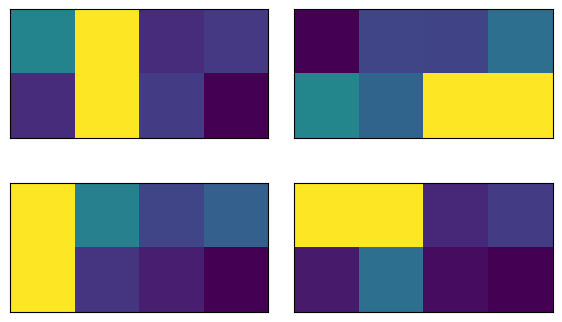

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(7, 7), subplot_kw={"xticks": [], "yticks": []})   # show 4 images, 2 above and 2 below

for i in range(4):
  ax[i // 2, i % 2].imshow(                                                             # display data as an image
    train_images[i].reshape(2, 4),                                                      # reshape the flattened image of 8 consecutive values ​​to be 2x4 pixels
    aspect="equal"
  )

plt.subplots_adjust(wspace=0.1, hspace=0.005, bottom=0.005, top=0.5)

Now let's start working on defining our QCNN.

First, we'll create the Convolutional Layer. To do this, we need to define a two-qubit unitary gate as described in section 5.2.2. This will allow us to use alternating even/odd entangling.

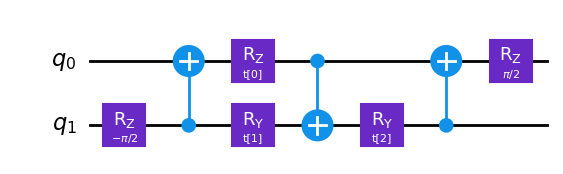

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def conv_circuit(params):

  target = QuantumCircuit(2)                  # two-qubit unitary gate
  target.rz(-np.pi / 2, 1)                    # fixed rotation at -pi/2
  target.cx(1, 0)
  target.rz(params[0], 0)                     # rotation 'theta'
  target.ry(params[1], 1)                     # rotation 'phi'
  target.cx(0, 1)
  target.ry(params[2], 1)                     # rotation 'lambda'
  target.cx(1, 0)
  target.rz(np.pi / 2, 0)                     # fixed rotation at pi/2
  return target


params = ParameterVector("t", length=3)       # created a vector of parameters just to be able to draw the circuit
circuit = conv_circuit(params)                # create a two-qubit unitary gate for illustrative purposes

circuit.draw(output="mpl", style="textbook", scale=1)

With this, we can create a function that defines the complete Convolutional Layer of our QCNN.

We'll apply the two-qubit unitary gate (using the `conv_circuit` function) to neighboring qubits.

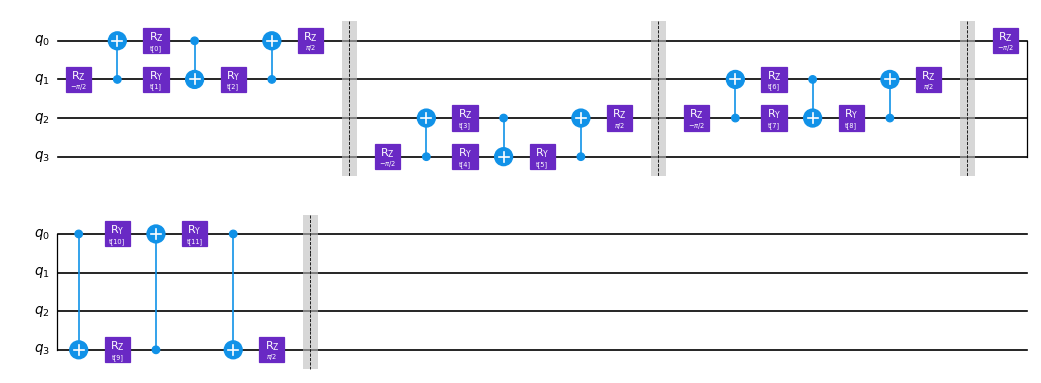

In [ ]:
def conv_layer(num_qubits, param_prefix):

  qc = QuantumCircuit(num_qubits, name="Convolutional Layer")                           # circuit name
  qubits = list(range(num_qubits))
  param_index = 0
  params = ParameterVector(param_prefix, length=num_qubits * 3)                         # there are 3 parameters for each neighboring qubits being coupled

  for q1, q2 in zip(qubits[0::2], qubits[1::2]):                                        # apply the two-qubit unitary to all even pairs
    qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])    # the elements of the parameter array are used consecutively
    qc.barrier()                                                                        # add barriers for convenience when drawing
    param_index += 3

  for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):                                  # apply the two-qubit unitary to all odd pairs in a circular coupling manner
    qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
    qc.barrier()
    param_index += 3

  qc_inst = qc.to_instruction()                      # convert the circuit as a single instruction (gate)

  qc = QuantumCircuit(num_qubits)                    # the circuit that is returned is the one with a single gate (with the entire convolutional layer)
  qc.append(qc_inst, qubits)

  return qc


circuit = conv_layer(4, "t")                         # create a convolutional layer for illustrative purposes

circuit.decompose().draw(output="mpl", style="textbook", scale=0.6)       # necessary to break it down to see the content

Now we will create the Pooling Layer. To achieve this, we will first define the two-qubit unitary as described in section 5.3.2.

The objective is to transform an $N$-qubit system into an $N/2$-qubit system, in particular for $N=2$ qubits.

So after applying the two-qubit unitary, we will ignore the first qubit (the one on top) in subsequent layers and only use the second qubit (the one on the bottom) in the QCNN.

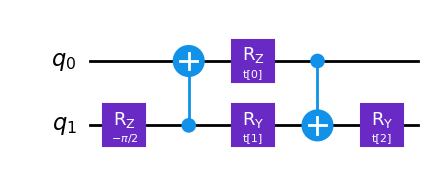

In [ ]:
def pool_circuit(params):

  target = QuantumCircuit(2)                  # two-qubit unitary gate
  target.rz(-np.pi / 2, 1)                    # fixed rotation at -pi/2
  target.cx(1, 0)
  target.rz(params[0], 0)                     # rotation 'theta_0'
  target.ry(params[1], 1)                     # rotation 'theta_1'
  target.cx(0, 1)
  target.ry(params[2], 1)                     # rotation 'theta_2'

  return target


params = ParameterVector("t", length=3)       # created a vector of parameters just to be able to draw the circuit
circuit = pool_circuit(params)                # create a two-qubit unitary gate for illustrative purposes

circuit.draw(output="mpl", style="textbook", scale=1)

With this, we can create a function that defines the complete Pooling Layer of our QCNN.

We'll apply the previous two-qubit unitary gate (using the `pool_circuit` function) to the indicated pairs of qubits.

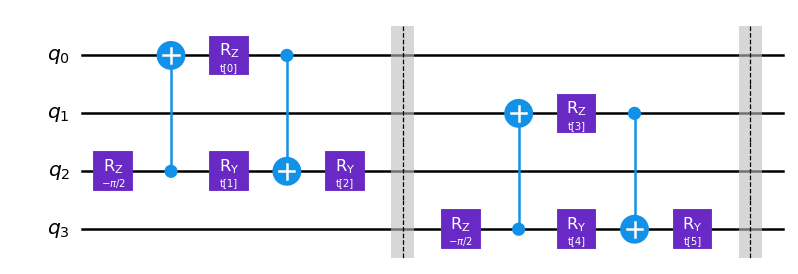

In [ ]:
def pool_layer(sources, targets, param_prefix):

  num_qubits = len(sources) + len(targets)
  qc = QuantumCircuit(num_qubits, name="Pooling Layer")                   # circuit name
  param_index = 0
  params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)      # there are 3 parameters for each pair of qubits

  for source, target in zip(sources, targets):                            # apply the two-qubit unitary to the indicated pairs
                                                                          # the first index is obtained from 'sources' and the second from 'targets'

    qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, target])

    qc.barrier()                                                          # add barriers for convenience when drawing
    param_index += 3

  qc_inst = qc.to_instruction()                               # convert the circuit as a single instruction (gate)

  qc = QuantumCircuit(num_qubits)                             # the circuit that is returned is the one with a single gate (with the entire convolutional layer)
  qc.append(qc_inst, range(num_qubits))

  return qc


sources = [0, 1]
targets = [2, 3]
circuit = pool_layer(sources, targets, "t")                               # create a pooling layer for illustrative purposes

circuit.decompose().draw(output="mpl", style="textbook", scale=0.9)       # necessary to break it down to see the content

Recall that our $2\times 4$ pixel images are flattened into an $8$-element array, so we will need $8$ qubits to encode the samples in our dataset.

We will use the [ZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZFeatureMap) feature map from the Qiskit circuit library.

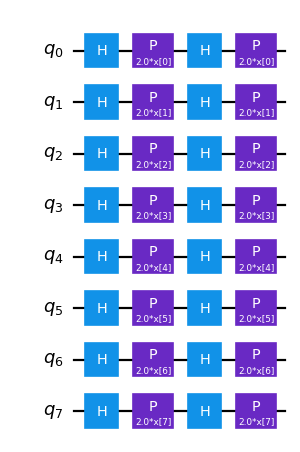

In [ ]:
from qiskit.circuit.library import ZFeatureMap


feature_map = ZFeatureMap(8)

feature_map.decompose().draw(output="mpl", style="textbook", scale=0.8)

Now we will create the complete circuit of our QCNN, which will consist of the feature map and three sets of alternating convolutional and pooling layers.

This will reduce the dimensionality of the QCNN from 8 to 1 qubits to be measured at the end.

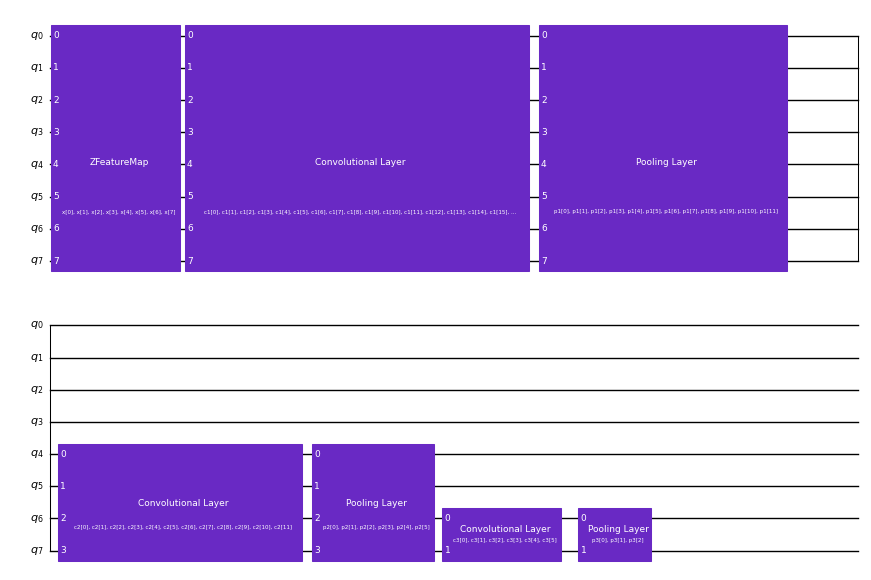

In [ ]:
ansatz = QuantumCircuit(8, name="Ansatz")

ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)                             # first Convolutional Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)    # first Pooling Layer

ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)                          # second Convolutional Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)             # second Pooling Layer

ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)                          # third Convolutional Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)                   # third Pooling Layer


circuit = QuantumCircuit(8)                                                                   # QCNN circuit
circuit.compose(feature_map, range(8), inplace=True)                                          # add the feature map
circuit.compose(ansatz, range(8), inplace=True)                                               # add the layers


circuit.draw(output="mpl", style="textbook", scale=0.5)

The result we're interested in is whether it's a horizontal or vertical line; that is, we want to measure the values $-1$ and $+1$. To achieve this, we choose the expected value of the Pauli Z ($\langle Z\rangle$), since it will give us exactly these two value as a result.

We'll use [SparsePauliOp](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp), which allows us to specify a list of Pauli basis to define an observable; we'll specify $Z$ for qubit $q_7$ and $I$ for the rest, since we're not interested in them.

In [ ]:
from qiskit.quantum_info import SparsePauliOp


observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])     # to measure in the Z basis the q7 qubit and with I the rest of the qubits

We will use the [EstimatorQNN](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) class, a neural network implementation based on the Estimator primitive.

An [Estimator primitive](https://medium.com/qiskit/what-are-qiskit-primitives-9bf63c1eacc7) computes expectation values of observables with respect to states prepared by quantum circuits.

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN


qcnn = EstimatorQNN(
  circuit=circuit.decompose(),
  observables=observable,
  input_params=feature_map.parameters,
  weight_params=ansatz.parameters
)

We define a function called `callback_plot`, which will be called during the execution of the training process, it will plot the progress of the cost function value as it is modified.

In [ ]:
from IPython.display import clear_output, display


objective_func_vals = []                              # to store the full history

def callback_plot(weights, obj_func_eval):
  plt.clf()
  objective_func_vals.append(obj_func_eval)
  plt.title("Loss function value versus iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  display(plt.gcf())
  clear_output(wait=True)

The QCNN model might take a long time to finish training, so we'll define a starting point for the weight values. This starting point was obtained from a pre-training process of this same model.

In [ ]:
initial_point = [1.68270961, 0.11605051, 0.34864916, 0.74675878, 1.87124355, 1.49219533, -0.38654013, 1.6794744, 1.46546974, 2.16547249, 1.05274095, 2.2565039, 0.31246977, -0.0977787, 0.26751274, -0.24319314, 0.28359516, 0.17431664, 0.86434056, 1.08183541, 1.64600062, 2.17350294, 0.17430376, 0.08381051, 0.30748524, 1.6671458, 0.23076889, 0.40720057, -0.38243368, -0.28842447, 0.08507067, 1.34472166, -0.08210173, 1.10931829, 0.15418569, 0.65755067, 3.09541972, 0.41647156, 1.12894435, 1.03898584, 0.64931532, -0.43442102, 0.24324246, 0.98370841, 0.57256531, 0.25832156, 0.42749823, 1.78949614, 0.27749909, 0.07237166, 0.05920573, 0.41896919, 0.66868785, 0.73035314, 0.00984019, 0.72243278, 1.10299638, 0.80821682, 0.39530007, 1.03814133, 0.41697893, 0.53016156, 1.13594375]

Now we define a [NeuralNetworkClassifier](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html) object that will allow us to perform the training.

We will specify our QCNN that we defined above, as well as a [COBYLA](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.COBYLA.html) optimizer, the function that will allow us to observe the progress of the loss function value, and the starting point for the weight values.

In [ ]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA


classifier = NeuralNetworkClassifier(
  qcnn,
  optimizer=COBYLA(maxiter=200),
  callback=callback_plot,
  initial_point=initial_point,
)

Let's train our QCNN using the training data obtained from our generated dataset.

Training time: 184 seconds


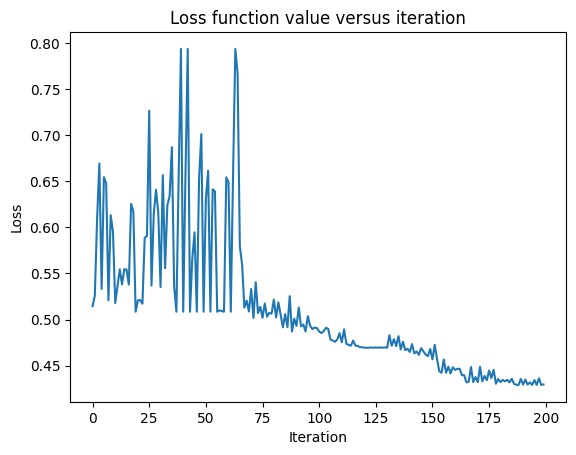

In [ ]:
import time


objective_func_vals = []                                # we make sure the history is empty

x_train = np.asarray(train_images)                      # convert to the required type
y_train = np.asarray(train_labels)

start = time.time()
classifier.fit(x_train, y_train)                        # adjust the data
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")       # how long the training took

Let's see how the quantum model works on the dataset, both the training and test data.

In [ ]:
x_test = np.asarray(test_images)   # convert to the required type
y_test = np.asarray(test_labels)


train_score = np.round(100 * classifier.score(x_train, y_train), 2)
test_score = np.round(100 * classifier.score(x_test, y_test), 2)


print(f"QCNN accuracy on the training dataset: {train_score}%")
print(f"QCNN accuracy on the test dataset:     {test_score}%")

QCNN accuracy on the training dataset: 97.14%
QCNN accuracy on the test dataset:     93.33%


Let's look at some examples of what our model predicts on unseen data (test dataset).

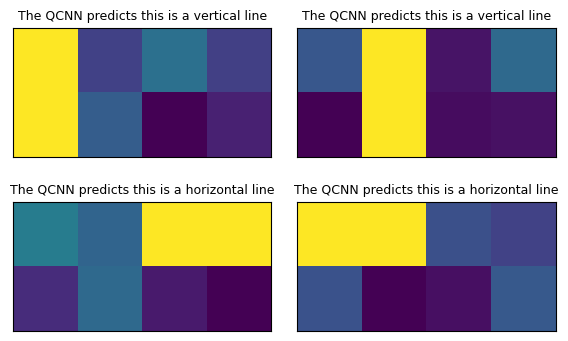

In [ ]:
y_predict = classifier.predict(test_images)


fig, ax = plt.subplots(2, 2, figsize=(7, 7), subplot_kw={"xticks": [], "yticks": []})

for i in range(4):          # display the first 4 images of the test dataset

  ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
  if y_predict[i] == -1:
    ax[i // 2, i % 2].set_title("The QCNN predicts this is a horizontal line", size=9)
  if y_predict[i] == +1:
    ax[i // 2, i % 2].set_title("The QCNN predicts this is a vertical line", size=9)


plt.subplots_adjust(wspace=0.1, hspace=0.005, bottom=0.005, top=0.5)